In [1]:
import wobble
import matplotlib.pyplot as plt
import numpy as np

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
data = wobble.Data('hip54287_e2ds.hdf5', filepath='data/', orders=[30])

In [3]:
model = wobble.Model(data)
model.add_star('hip54287b')
model.add_telluric('tellurics')
print(model)

Model consisting of the following components: ['hip54287b', 'tellurics']


Inject some noise & try to get back to the pipeline values by optimizing:

In [4]:
import tensorflow as tf
session = wobble.get_session()
session.run(tf.global_variables_initializer())
pipeline_rvs = session.run(model.components[0].rvs_block[0])
model.components[0].rvs_block[0].load(pipeline_rvs + np.random.normal(0., 100., data.N), session)

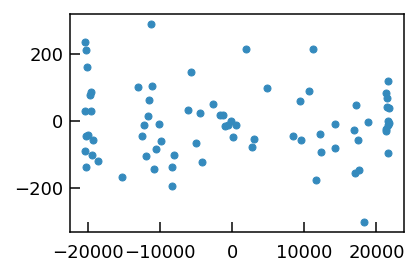

In [5]:
star_rvs = session.run(model.components[0].rvs_block[0])
initial_rvs = np.copy(star_rvs)
plt.scatter(data.pipeline_rvs, star_rvs + data.pipeline_rvs)

In [6]:
#plt.plot(session.run(data.xs[0][0,:]), session.run(data.ys[0][0,:]))
#plt.plot(session.run(data.xs[0][5,:]), session.run(data.ys[0][5,:]))

In [7]:
#for c in model.components:
#    c.initialize_model(0, data)
#    session.run(tf.variables_initializer([c.model_xs[0], c.model_ys[0]]))

In [8]:
#for c in model.components:
#    model_xs = session.run(c.model_xs[0])
#    model_ys = session.run(c.model_ys[0])
#    plt.plot(model_xs, model_ys)

In [9]:
%%time
niter = 100
nll_history, rvs_history, model_history = wobble.optimize_order(model, data, 0, niter=niter, output_history=True)

initializing star model...
initializing tellurics model...


  0%|          | 0/100 [00:00<?, ?it/s]

--- ORDER 0 ---


100%|██████████| 100/100 [00:22<00:00,  4.51it/s]

CPU times: user 1min 7s, sys: 7.84 s, total: 1min 14s
Wall time: 42.6 s


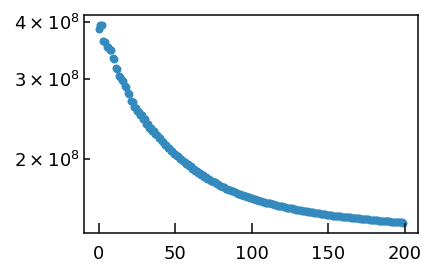

In [10]:
plt.scatter(np.arange(len(nll_history)), nll_history)
ax = plt.gca()
ax.set_yscale('log')

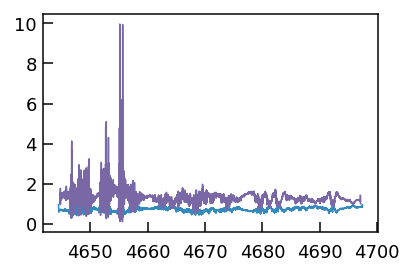

In [11]:
for c in model.components:
    model_xs = session.run(c.model_xs[0])
    model_ys = session.run(c.model_ys[0])
    plt.plot(np.exp(model_xs), np.exp(model_ys))

In [12]:
#star_rvs = session.run(model.components[0].rvs_block[0])
#plt.scatter(data.pipeline_rvs, initial_rvs + data.pipeline_rvs, color='k', alpha=0.6)
#plt.scatter(data.pipeline_rvs, star_rvs + data.pipeline_rvs, color='r', alpha=0.6)

In [13]:
from IPython.display import HTML
ani = wobble.plot_rv_history(data, rvs_history, niter, 50, ylims=[-1500, 1500])
HTML(ani.to_html5_video())

In [ ]:
#model_xs = session.run(model.components[0].model_xs[0])
#ani = wobble.plot_model_history(model_xs, model_history, niter, 50)
#HTML(ani.to_html5_video())

Gradient checks:

In [17]:
tf_grad = session.run(model.components[0].gradients_rvs)[0]

In [18]:
r = 0
rvs = tf.placeholder(tf.float64, (75,))
synth = model.components[1].shift_and_interp(r, data.xs[r], model.components[1].rvs_block[r])
synth += model.components[0].shift_and_interp(r, data.xs[r], rvs)
nll = 0.5*tf.reduce_sum(tf.square(data.ys[r] - synth) * data.ivars[r])

In [19]:
num_grads = np.zeros_like(tf_grad)
rvs0 = session.run(model.components[0].rvs_block[0])
nll_0 = session.run(nll, feed_dict={rvs:rvs0})
d_rvs = 0.001
for n in range(75):
    rvs1 = np.copy(rvs0)
    rvs1[n] += d_rvs
    nll_1 = session.run(nll, feed_dict={rvs:rvs1})
    num_grads[n] = np.copy((nll_1 - nll_0)/d_rvs)
print("Fractional difference between numerical gradients & TF gradient at each RV_star:")
print((num_grads - tf_grad) / np.median(np.abs(tf_grad)))

Fractional difference between numerical gradients & TF gradient at each RV_star:
[ 4.40880030e-05  2.48016389e-04  2.59357736e-04 -4.29362275e-03
 -2.37495208e-04  1.33527606e-04 -5.59455640e-05  3.35088537e-04
 -2.58280378e-04 -2.85092557e-04  1.84725370e-04  1.75832556e-04
  3.77836132e-04  3.77898564e-04 -1.19474957e-03  6.52236605e-04
  1.06932398e-04  2.11008729e-05  1.98251779e-03  2.65141712e-04
  1.99239156e-04  6.07549531e-04  4.06772434e-04  1.48299674e-04
  5.98772343e-04  3.16144733e-04  8.89826903e-05  6.74181942e-05
  3.74249075e-04  1.43489245e-04  4.56223342e-04  2.43752071e-04
  3.52375999e-04  1.23680015e-04  2.11634804e-04  3.77973820e-04
  3.33659656e-04 -1.86639038e-04  3.65287777e-04 -3.43327554e-04
 -1.37446597e-03 -1.37709034e-03 -3.06178196e-04 -4.02163898e-04
  2.35781061e-04  3.23704801e-04  1.22980810e-03 -1.28833752e-04
  1.26556454e-03  3.76976153e-04 -2.47256393e-04  3.58569128e-04
  6.43601770e-05 -3.06328360e-05  1.36249963e-04  2.48654970e-04
  2.39729

In [28]:
from wobble.interp import interp
model_len = 6815

model_ys = tf.placeholder(tf.float64, (model_len,))
shifted_xs = data.xs[r] + tf.log(wobble.doppler((model.components[0].rvs_block[r])[:, None]))
synth = interp(shifted_xs, model.components[0].model_xs[r], model_ys) 
synth += model.components[1].shift_and_interp(r, data.xs[r], model.components[1].rvs_block[r])
nll = 0.5*tf.reduce_sum(tf.square(data.ys[r] - synth) * data.ivars[r])

In [29]:
tf_grad = session.run(model.components[0].gradients_model)[0]
dense_grad = np.zeros(model_len)
for i in range(model_len):
    dense_grad[i] = np.sum(tf_grad.values[tf_grad.indices == i])

In [30]:
model0 = session.run(model.components[0].model_ys[0])
nll_0 = session.run(nll, feed_dict={model_ys:model0})
d_model = 0.001
diff = []
for n in np.random.randint(0, model_len, size=20):
    model1 = np.copy(model0)
    model1[n] += d_model
    nll_1 = session.run(nll, feed_dict={model_ys:model1})
    diff.append((nll_1 - nll_0)/d_rvs - dense_grad[n])
print("Fractional difference between numerical gradients & TF gradient for random model pixels:")
print(diff / np.median(np.abs(dense_grad)))

Fractional difference between numerical gradients & TF gradient for random model pixels:
[0.1495599  0.12385944 0.10303528 0.12776617 0.10915661 0.11897443
 0.13532639 0.0966039  0.11220809 0.06841057 0.08675099 0.12808285
 0.1421868  0.117575   0.10053423 0.12681417 0.08332606 0.07501312
 0.08795179 0.08124156]


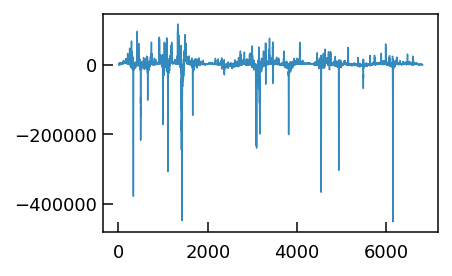

In [31]:
plt.plot(dense_grad)

In [27]:
model.components[0].model_ys

[<tf.Variable 'model_ys_star:0' shape=(6815,) dtype=float64_ref>]